# Лабораторная работа 1

***Борисов Дмитрий Сергеевич (6233-010402D)***

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [72]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import pandas as pd


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [7]:
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



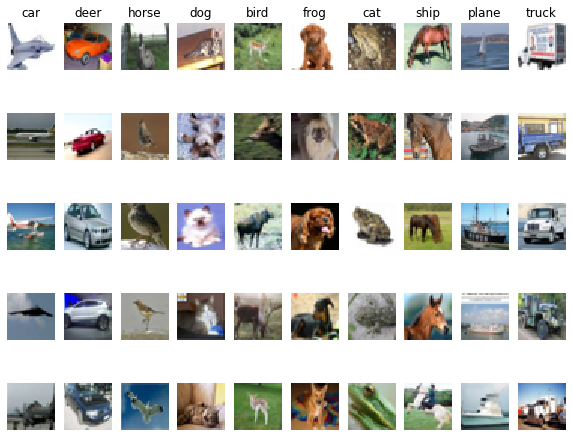

In [10]:
mapping_labels = ['car', 'deer', 'horse', 'dog', 'bird', 'frog',  'cat', 'ship', 'plane', 'truck']
n_classes = len(mapping_labels)
n_samples = 5

for class_index, class_name in enumerate(mapping_labels):
    class_indexes = np.random.choice(np.flatnonzero(y_train == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [86]:
train_mask = range(5000)
knn_X_train = X_train[train_mask]
knn_y_train = y_train[train_mask]

test_mask = range(500)
knn_X_test = X_test[test_mask]
knn_y_test = y_test[test_mask]

In [87]:
knn_X_train = np.reshape(knn_X_train, (knn_X_train.shape[0], -1))
knn_y_train = np.reshape(knn_y_train, (knn_y_train.shape[0],))
knn_X_test = np.reshape(knn_X_test, (knn_X_test.shape[0], -1))
knn_y_test = np.reshape(knn_y_test, (knn_y_test.shape[0],))
print(knn_X_train.shape, knn_X_test.shape)

(5000, 3072) (500, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [88]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(knn_X_train, knn_y_train)

1.5 Выполните классификацию на тестовой выборке

In [89]:
%%time
dists_one_loop = classifier.compute_distances_one_loop(knn_X_test)

CPU times: user 5.91 s, sys: 59.7 ms, total: 5.97 s
Wall time: 5.96 s


In [90]:
%%time
dists_two_loops = classifier.compute_distances_two_loops(knn_X_test)

CPU times: user 23.3 s, sys: 310 ms, total: 23.7 s
Wall time: 23.4 s


In [91]:
%%time
dists_no_loops = classifier.compute_distances_no_loops(knn_X_test)

CPU times: user 4.43 s, sys: 4.6 ms, total: 4.44 s
Wall time: 4.43 s


In [92]:
print(dists_one_loop.shape)
print(dists_two_loops.shape)
print(dists_no_loops.shape)

(500, 5000)
(500, 5000)
(500, 5000)


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


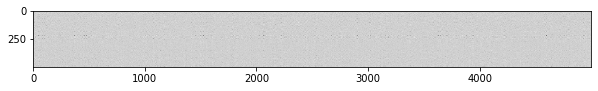

In [93]:
plt.imshow(dists_one_loop, interpolation='none')
plt.show()

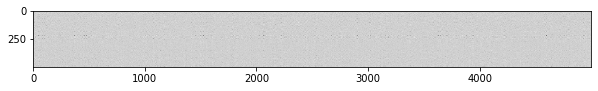

In [94]:
plt.imshow(dists_two_loops, interpolation='none')
plt.show()

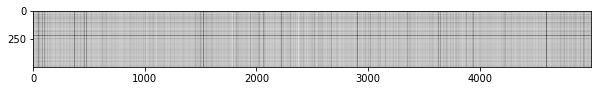

In [95]:
plt.imshow(dists_no_loops, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [38]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / np.sum(y_test.shape)

In [96]:
y_pred_one_loop = classifier.predict_labels(dists_one_loop)
print("accuracy with one loop: ", 
      accuracy(knn_y_test, y_pred_one_loop))

accuracy with one loop:  0.176


In [97]:
y_pred_two_loops = classifier.predict_labels(dists_two_loops)
print("accuracy with two loops: ", 
      accuracy(knn_y_test, y_pred_two_loops))

accuracy with two loops:  0.176


In [98]:
y_pred_no_loops = classifier.predict_labels(dists_no_loops)
print("accuracy with no loops: ", 
      accuracy(knn_y_test, y_pred_no_loops))

accuracy with no loops:  0.102


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [109]:
k_list = range(1, 15)
acc_dict = {'0 loops': [], '1 loop': [], '2 loops': []}

for k in k_list:
    print("current iteration: ", k)
    y_preds_with_0_loops = classifier.predict(knn_X_test, k=k, num_loops=0)
    y_preds_with_1_loops = classifier.predict(knn_X_test, k=k, num_loops=1)
    y_preds_with_2_loops = classifier.predict(knn_X_test, k=k, num_loops=2)
    acc_dict['0 loops'].append(accuracy(y_preds_with_0_loops, knn_y_test))
    acc_dict['1 loop'].append(accuracy(y_preds_with_1_loops, knn_y_test))
    acc_dict['2 loops'].append(accuracy(y_preds_with_2_loops, knn_y_test))

current iteration:  1
current iteration:  2
current iteration:  3
current iteration:  4
current iteration:  5
current iteration:  6
current iteration:  7
current iteration:  8
current iteration:  9
current iteration:  10
current iteration:  11
current iteration:  12
current iteration:  13
current iteration:  14


In [110]:
acc_df = pd.DataFrame(acc_dict, index=k_list)
acc_df

,0 loops,1 loop,2 loops
1,0.102,0.176,0.176
2,0.114,0.188,0.188
3,0.102,0.208,0.208
4,0.114,0.210,0.210
5,0.124,0.200,0.200
6,0.114,0.230,0.230
7,0.114,0.216,0.216
8,0.114,0.226,0.226
9,0.114,0.226,0.226
10,0.114,0.214,0.214


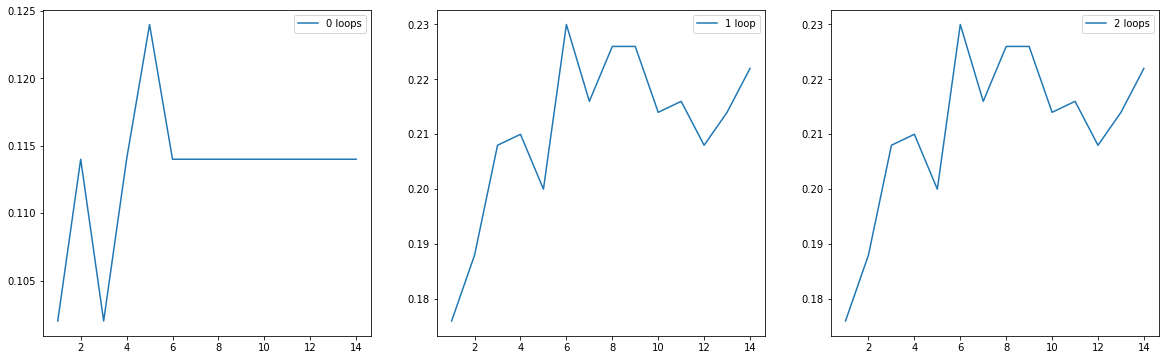

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
acc_df.plot(y='0 loops', kind='line', ax=ax1)
acc_df.plot(y='1 loop', kind='line', ax=ax2)
acc_df.plot(y='2 loops', kind='line', ax=ax3)

In [120]:
best_k_for_loops = acc_df.idxmax()
print(f"Best k for classification:\n", best_k_for_loops, sep='')

Best k for classification:
0 loops    5
1 loop     6
2 loops    6
dtype: int64


1.9 Выберите лучшее значение параметра k на основе кросс-валидации.



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [124]:
new_classifier = KNearestNeighbor()
new_classifier.train(knn_X_train, knn_y_train)

In [129]:
y_pred_one_loop_with_best_k = new_classifier.predict_labels(dists_one_loop, 
                                                            k=best_k_for_loops['1 loop'])
print("accuracy with one loop with best k: ", 
      accuracy(knn_y_test, y_pred_one_loop_with_best_k))

accuracy with one loop with best k:  0.23


In [131]:
y_pred_two_loops_with_best_k = new_classifier.predict_labels(dists_two_loops, 
                                                            k=best_k_for_loops['2 loops'])
print("accuracy with one loop with best k: ", 
      accuracy(knn_y_test, y_pred_two_loops_with_best_k))

accuracy with one loop with best k:  0.23


In [132]:
y_pred_no_loops_with_best_k = new_classifier.predict_labels(dists_no_loops, 
                                                            k=best_k_for_loops['0 loops'])
print("accuracy with one loop with best k: ", 
      accuracy(knn_y_test, y_pred_no_loops_with_best_k))

accuracy with one loop with best k:  0.124


1.11 Сделайте выводы по результатам 1 части задания.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [ ]:

from scripts.classifiers.linear_svm import svm_loss_naive
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))


2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

2.9 Сделайте выводы по второй части задания